# Classificação de Comandos de Voz usando Google Speech Commands.

Inicialmente, o objetivo deste projeto era integrar os modelos treinados em uma aplicação prática para controle básico do mouse via comandos de voz simples. No entanto, devido a restrições de tempo, a implementação desta etapa da aplicação não foi concluída.

**Dataset:** Google Speech Commands
* Áudios: Mono, 16000Hz.
* Classes Originais: 30. 
* Classes Alvo (Controle de Mouse): 20 (down, eight, five, four, go, left, nine, no, off, on, one, right, seven, six, stop, three, two, up, yes, zero).
* Distribuição: 
    - Treino (37.158), 
    - Validação (5.071), 
    - Teste (5.119). 
    - Dataset balanceado (~2400 arquivos por classe).

**Abordagem Inicial (Áudio Bruto - Downsampled):**

Inicialmente, exploramos a ideia de utilizar o **áudio bruto diretamente** como entrada para o modelo. Para contornar o desafio do comprimento dos áudios, aplicamos um *downsampling*, reduzindo cada clipe para **4000 amostras**. 

Treinamos para isso um modelo **LSTM Simples** com 3 camadas LSTM(64), LayerNormalization, Dropout e uma camada Dense de output, totalizando **88.916 parâmetros**. Contudo, essa abordagem **não se mostrou eficaz**, resultando em uma acurácia de teste de apenas **0.0502** (muito próximo dos 5% esperados de um modelo aleatório). Isso nos levou a concluir que o uso direto do áudio bruto não era adequado para a tarefa.

Diante do resultado da abordagem inicial, a estratégia seguinte foi utilizar **MFCCs (Coeficientes de Cepstro Frequencial Mel)**.

* **MFCCs** são uma forma de representar o som que foca nas características importantes para a fala humana, como o timbre e o tom, de maneira mais compacta que o áudio bruto. Ao contrário do áudio bruto, que contém muita informação redundante para tarefas de classificação, os MFCCs capturam eficientemente os aspectos relevantes do som, reduzindo drasticamente a quantidade de dados necessários e tornando o problema mais tratável para os modelos.

* **Entrada para o Modelo:** Os MFCCs foram extraídos de forma a gerar uma sequência de **(30, 40)** para cada áudio. Isso significa 30 "quadros" de tempo, cada um descrito por 40 coeficientes MFCC. Embora o total seja de 1200 pontos de entrada por áudio (30 * 40), a grande diferença em relação às 4000 amostras do áudio bruto downsampled é que **esses 1200 pontos de MFCC representam características acústicas importantes e já processadas**, muito mais relevantes para a tarefa de identificar o comando de voz.

## Preparando os dados e criandos os datasets

In [ ]:
# Importando bibliotecas

import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import json

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Definindo parâmetros

data_dir = 'Data'

audio_base_dir = data_dir

test_list_file = os.path.join(data_dir, 'testing_list.txt')
validation_list_file = os.path.join(data_dir, 'validation_list.txt')

TARGET_CLASSES = ['down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up', 'yes', 'zero']


SAMPLE_RATE = 16000  
DURATION = 1         
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION 
N_FFT = 1024         
HOP_LENGTH = 512     
N_MEL_BINS = 80      
N_MFCC = 40          

MAX_SEQUENCE_LENGTH = 30

BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE 
EPOCHS = 20 

test_files = set()
validation_files = set()

In [ ]:
# Prepara os dados de áudio e seus rótulos, dividindo em conjuntos de treino, validação e teste

def format_relative_path(path):
    return path.replace(os.sep, '/')

try:
    with open(test_list_file, 'r') as f:
        for line in f:
            test_files.add(format_relative_path(line.strip()))

    with open(validation_list_file, 'r') as f:
        for line in f:
            validation_files.add(format_relative_path(line.strip()))

    print(f"Carregados {len(test_files)} caminhos do arquivo de teste.")
    print(f"Carregados {len(validation_files)} caminhos do arquivo de validação.")

except FileNotFoundError as e:
    print(f"Erro: O arquivo de lista não foi encontrado. Verifique se o caminho '{e.filename}' está correto.")
    exit()

train_audio_paths = []
train_labels = []
validation_audio_paths = []
validation_labels = []
test_audio_paths = []
test_labels = []

all_classes = [name for name in os.listdir(audio_base_dir) if os.path.isdir(os.path.join(audio_base_dir, name)) and name != '_background_noise_']

print(f"\nTodas as classes encontradas: {all_classes}")
print(f"Classes alvo para o treinamento: {TARGET_CLASSES}")

for label in TARGET_CLASSES:
    class_dir = os.path.join(audio_base_dir, label)

    for filename in os.listdir(class_dir):
        if filename.endswith('.wav'):
            audio_path = os.path.join(class_dir, filename)
            relative_audio_path = os.path.join(label, filename)
            formatted_relative_audio_path = format_relative_path(relative_audio_path)

            if formatted_relative_audio_path in validation_files:
                validation_audio_paths.append(audio_path)
                validation_labels.append(label)
            elif formatted_relative_audio_path in test_files:
                test_audio_paths.append(audio_path)
                test_labels.append(label)
            else:
                train_audio_paths.append(audio_path)
                train_labels.append(label)

print(f"Total de arquivos de treino: {len(train_audio_paths)}")
print(f"Total de arquivos de validação: {len(validation_audio_paths)}")
print(f"Total de arquivos de teste: {len(test_audio_paths)}")

label_encoder = LabelEncoder()
label_encoder.fit(TARGET_CLASSES)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_onehot = to_categorical(train_labels_encoded, num_classes=len(TARGET_CLASSES))
validation_labels_onehot = to_categorical(validation_labels_encoded, num_classes=len(TARGET_CLASSES))
test_labels_onehot = to_categorical(test_labels_encoded, num_classes=len(TARGET_CLASSES))

print(f"\nRótulos codificados para one-hot: {train_labels_onehot.shape}")

Carregados 6835 caminhos do arquivo de teste.
Carregados 6798 caminhos do arquivo de validação.

Todas as classes encontradas: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Classes alvo para o treinamento: ['down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up', 'yes', 'zero']
Total de arquivos de treino: 37158
Total de arquivos de validação: 5071
Total de arquivos de teste: 5119

Rótulos codificados para one-hot: (37158, 20)


In [ ]:
# Função para pré-processar um arquivo de áudio, extraindo características MFCC.
def preprocess_audio(audio_path):
    audio_binary = tf.io.read_file(audio_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)

    
    audio = audio[:SAMPLES_PER_CLIP]
    zero_padding = tf.zeros([SAMPLES_PER_CLIP] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)

    stft = tf.signal.stft(audio, frame_length=N_FFT, frame_step=HOP_LENGTH)
    spectrogram = tf.abs(stft)

    num_spectrogram_bins = tf.shape(spectrogram)[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        N_MEL_BINS, num_spectrogram_bins, SAMPLE_RATE, 0, SAMPLE_RATE/2)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6) 

    mfccs = tf.signal.dct(log_mel_spectrogram, type=2, norm='ortho')[:, :N_MFCC]

    current_sequence_length = tf.shape(mfccs)[0]
    padding_size = MAX_SEQUENCE_LENGTH - current_sequence_length

    if padding_size > 0:
        mfccs = tf.pad(mfccs, [[0, padding_size], [0, 0]], "CONSTANT", constant_values=tf.constant(0.0, dtype=mfccs.dtype))

    mfccs = mfccs[:MAX_SEQUENCE_LENGTH, :] 

    return mfccs

In [8]:
def make_dataset(audio_paths, labels_onehot, shuffle=False):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels_onehot)

    audio_ds = path_ds.map(preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((audio_ds, label_ds))

    if shuffle:
        shuffle_buffer_size = len(audio_paths)
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(BUFFER_SIZE)

    return dataset

print("\nCriando datasets...")
train_ds = make_dataset(train_audio_paths, train_labels_onehot, shuffle=True)
validation_ds = make_dataset(validation_audio_paths, validation_labels_onehot)
test_ds = make_dataset(test_audio_paths, test_labels_onehot)

print("Datasets criados.")


Criando datasets...
Datasets criados.


## Modelos Avaliados

Aqui estão os resultados da avaliação de diferentes arquiteturas de redes neurais para a tarefa em questão:

### LSTM Simples
* **Arquitetura:** Input -> LSTM(64) -> Dense(20, softmax)
* **Parâmetros:** 28.180
* **Acurácia Teste:** 0.8855
* **Observação:** Modelo base com arquitetura simples de uma única camada LSTM.

### LSTM + Normalização + Dropout
* **Arquitetura:** Input -> LSTM(64) -> LayerNorm -> Dropout(0.3) -> Dense(20, softmax)
* **Parâmetros:** 28.308
* **Acurácia Teste:** 0.8883
* **Observação:** Apresentou uma melhora marginal na acurácia com a adição de regularização (Normalização de Camada e Dropout).

### LSTM + Camada Densa Oculta
* **Arquitetura:** Input -> LSTM(64) -> LayerNorm -> Dropout(0.3) -> Dense(64, relu) -> LayerNorm -> Dropout(0.3) -> Dense(20, softmax)
* **Parâmetros:** 32.596
* **Acurácia Teste:** 0.8789
* **Observação:** A inclusão de uma camada densa intermediária resultou em uma leve queda na acurácia final, embora tenha apresentado um comportamento de convergência distinto (inicialmente mais lento, mas atingindo um patamar similar).

### LSTM (3 Camadas) + Camada Densa Oculta
* **Arquitetura:** Input -> LSTM(64, return_sequences=True) -> LayerNorm -> Dropout -> LSTM(64, return_sequences=True) -> LayerNorm -> Dropout -> LSTM(64) -> LayerNorm -> Dropout -> Dense(64, relu) -> LayerNorm -> Dropout -> Dense(20, softmax)
* **Parâmetros:** 98.900
* **Acurácia Teste:** 0.9156
* **Observação:** Obteve o melhor desempenho entre todos os modelos avaliados, superando as arquiteturas com menos camadas LSTM. O aumento na complexidade do modelo resultou em maior capacidade de aprendizado.

### SimpleRNN (3 Camadas)
* **Arquitetura:** Input -> SimpleRNN(64, return_sequences=True) -> LayerNorm -> Dropout -> SimpleRNN(64, return_sequences=True) -> LayerNorm -> Dropout -> SimpleRNN(64) -> LayerNorm -> Dropout -> Dense(20, softmax)
* **Parâmetros:** 24.916
* **Acurácia Teste:** 0.2948
* **Observação:** Apresentou um desempenho muito inferior aos modelos baseados em LSTM. Atingiu um platô de treinamento rapidamente, indicando dificuldade em capturar as dependências temporais complexas dos dados, em comparação com as LSTMs.

In [7]:
checkpoint_dir = './checkpoints_models' 
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
print("\nDefinindo o modelo LSTM...")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, N_MFCC)),
        
    tf.keras.layers.LSTM(64),
    
    tf.keras.layers.Dense(len(TARGET_CLASSES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\nIniciando treinamento...")

filepath = os.path.join(checkpoint_dir, 'best_lstm_1_weights.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,                 
    monitor='val_loss',             
    save_best_only=True,               
    save_weights_only=True,           
    mode='min',                        
    verbose=1                          
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback] 
)

print("\nSalvando o histórico de treinamento...")
history_filepath = os.path.join(checkpoint_dir, 'training_history_lstm_1.json')
try:
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)
    print(f"Histórico de treinamento salvo em: {history_filepath}")
except Exception as e:
    print(f"Erro ao salvar o histórico de treinamento: {e}")

print("Treinamento finalizado.")

print("\nAvaliando o modelo no conjunto de teste...")
model.load_weights(filepath)
loss, accuracy = model.evaluate(test_ds)

print(f"\nPerda no conjunto de teste: {loss:.4f}")
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")


Definindo o modelo LSTM...


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,180 (110.08 KB)

 Trainable params: 28,180 (110.08 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3502 - loss: 2.1316
Epoch 1: val_loss improved from inf to 0.67864, saving model to ./checkpoints_models\best_lstm_1_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3503 - loss: 2.1310 - val_accuracy: 0.8036 - val_loss: 0.6786
Epoch 2/20
1159/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8208 - loss: 0.5992
Epoch 2: val_loss improved from 0.67864 to 0.50324, saving model to ./checkpoints_models\best_lstm_1_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8209 - loss: 0.5990 - val_accuracy: 0.8413 - val_loss: 0.5032
Epoch 3/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8779 - loss: 0.4117
Epoch 3: val_loss improved from 0.50324 to 0.46492, saving model to ./checkpoints_models\best_lstm_1_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8779 - loss: 0.4117 - val_accuracy: 0.8541 - val_loss

In [ ]:
print("\nDefinindo o modelo LSTM...")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, N_MFCC)),

    tf.keras.layers.LSTM(64),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(TARGET_CLASSES), activation='softmax')
])

print("\nCompilando o modelo...")
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\nIniciando treinamento...")

filepath = os.path.join(checkpoint_dir, 'best_lstm_2_weights.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,                 
    monitor='val_loss',              
    save_best_only=True,               
    save_weights_only=True,            
    mode='min',                       
    verbose=1                          
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS, 
    callbacks=[model_checkpoint_callback] 
)

print(f"Treinamento finalizado após {EPOCHS} épocas.")

print("\nSalvando o histórico de treinamento...")
history_filepath = os.path.join(checkpoint_dir, 'training_history_lstm_2.json')
try:
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)
    print(f"Histórico de treinamento salvo em: {history_filepath}")
except Exception as e:
    print(f"Erro ao salvar o histórico de treinamento: {e}")

print(f"\nCarregando os melhores pesos salvos de volta no modelo a partir de: {filepath}")
model.load_weights(filepath)
print("Melhores pesos carregados.")

print("\nAvaliando o modelo (com melhores pesos carregados) no conjunto de teste...")

loss, accuracy = model.evaluate(test_ds)

print(f"\nPerda no conjunto de teste (Melhores Pesos): {loss:.4f}")
print(f"Acurácia no conjunto de teste (Melhores Pesos): {accuracy:.4f}")


Definindo o modelo LSTM...

Compilando o modelo...


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,308 (110.58 KB)

 Trainable params: 28,308 (110.58 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/20
1159/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2549 - loss: 2.5098
Epoch 1: val_loss improved from inf to 0.80000, saving model to ./checkpoints_models\best_lstm_2_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2556 - loss: 2.5074 - val_accuracy: 0.7584 - val_loss: 0.8000
Epoch 2/20
1158/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7568 - loss: 0.8225
Epoch 2: val_loss improved from 0.80000 to 0.53242, saving model to ./checkpoints_models\best_lstm_2_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7569 - loss: 0.8221 - val_accuracy: 0.8355 - val_loss: 0.5324
Epoch 3/20
1161/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8433 - loss: 0.5421
Epoch 3: val_loss improved from 0.53242 to 0.46315, saving model to ./checkpoints_models\best_lstm_2_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8433 - loss: 0.5420 - val_accuracy: 0.8594 - val_lo

In [ ]:
print("\nDefinindo o modelo LSTM com camada densa oculta...")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, N_MFCC)),

    tf.keras.layers.LSTM(64),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(TARGET_CLASSES), activation='softmax')
])

print("\nCompilando o modelo...")
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\nIniciando treinamento...")

filepath = os.path.join(checkpoint_dir, 'best_lstm_4_weights.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,                 
    monitor='val_loss',              
    save_best_only=True,               
    save_weights_only=True,            
    mode='min',                        
    verbose=1                          
)


history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS, 
    callbacks=[model_checkpoint_callback] 
)

print(f"Treinamento finalizado após {EPOCHS} épocas.")

print("\nSalvando o histórico de treinamento...")
history_filepath = os.path.join(checkpoint_dir, 'training_history_lstm_4.json')
try:
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)
    print(f"Histórico de treinamento salvo em: {history_filepath}")
except Exception as e:
    print(f"Erro ao salvar o histórico de treinamento: {e}")

print(f"\nCarregando os melhores pesos salvos de volta no modelo a partir de: {filepath}")
model.load_weights(filepath)
print("Melhores pesos carregados.")

print("\nAvaliando o modelo (com melhores pesos carregados) no conjunto de teste...")

loss, accuracy = model.evaluate(test_ds)

print(f"\nPerda no conjunto de teste (Melhores Pesos): {loss:.4f}")
print(f"Acurácia no conjunto de teste (Melhores Pesos): {accuracy:.4f}")


Definindo o modelo LSTM com camada densa oculta...

Compilando o modelo...


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,596 (127.33 KB)

 Trainable params: 32,596 (127.33 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/20
1159/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1784 - loss: 2.7816
Epoch 1: val_loss improved from inf to 1.04154, saving model to ./checkpoints_models\best_lstm_4_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1789 - loss: 2.7795 - val_accuracy: 0.6874 - val_loss: 1.0415
Epoch 2/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6367 - loss: 1.1572
Epoch 2: val_loss improved from 1.04154 to 0.66387, saving model to ./checkpoints_models\best_lstm_4_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6367 - loss: 1.1571 - val_accuracy: 0.7949 - val_loss: 0.6639
Epoch 3/20
1160/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7722 - loss: 0.7501
Epoch 3: val_loss improved from 0.66387 to 0.54782, saving model to ./checkpoints_models\best_lstm_4_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7722 - loss: 0.7499 - val_accuracy: 0.8314 - val_loss: 0

In [ ]:
print("\nDefinindo o modelo LSTM com múltiplas camadas e camada densa oculta...")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, N_MFCC)),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64), 
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(TARGET_CLASSES), activation='softmax')
])

print("\nCompilando o modelo...")
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


print("\nIniciando treinamento...")

filepath = os.path.join(checkpoint_dir, 'best_lstm_5_weights.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,                 
    monitor='val_loss',             
    save_best_only=True,               
    save_weights_only=True,            
    mode='min',                        
    verbose=1                          
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS, 
    callbacks=[model_checkpoint_callback] 
)

print(f"Treinamento finalizado após {EPOCHS} épocas.")

print("\nSalvando o histórico de treinamento...")
history_filepath = os.path.join(checkpoint_dir, 'training_history_lstm_5.json')
try:
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)
    print(f"Histórico de treinamento salvo em: {history_filepath}")
except Exception as e:
    print(f"Erro ao salvar o histórico de treinamento: {e}")

print(f"\nCarregando os melhores pesos salvos de volta no modelo a partir de: {filepath}")
model.load_weights(filepath)
print("Melhores pesos carregados.")

print("\nAvaliando o modelo (com melhores pesos carregados) no conjunto de teste...")

loss, accuracy = model.evaluate(test_ds)

print(f"\nPerda no conjunto de teste (Melhores Pesos): {loss:.4f}")
print(f"Acurácia no conjunto de teste (Melhores Pesos): {accuracy:.4f}")


Definindo o modelo LSTM com múltiplas camadas e camada densa oculta...

Compilando o modelo...


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_24          │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_25          │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_26          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_27          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,900 (386.33 KB)

 Trainable params: 98,900 (386.33 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/20
1160/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2561 - loss: 2.5285
Epoch 1: val_loss improved from inf to 0.81234, saving model to ./checkpoints_models\best_lstm_5_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.2566 - loss: 2.5267 - val_accuracy: 0.7590 - val_loss: 0.8123
Epoch 2/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7516 - loss: 0.8821
Epoch 2: val_loss improved from 0.81234 to 0.58786, saving model to ./checkpoints_models\best_lstm_5_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.7516 - loss: 0.8820 - val_accuracy: 0.8292 - val_loss: 0.5879
Epoch 3/20
1159/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8359 - loss: 0.5989
Epoch 3: val_loss improved from 0.58786 to 0.48696, saving model to ./checkpoints_models\best_lstm_5_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.8359 - loss: 0.5987 - val_accuracy: 0.8568 - val_l

In [ ]:
print("\nDefinindo o modelo RNN (SimpleRNN) com três camadas empilhadas...") 

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, N_MFCC)),

    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(TARGET_CLASSES), activation='softmax')
])

print("\nCompilando o modelo...")
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


print("\nIniciando treinamento...")

filepath = os.path.join(checkpoint_dir, 'best_rnn_1_weights.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,                
    monitor='val_loss',             
    save_best_only=True,            
    save_weights_only=True,           
    mode='min',                       
    verbose=1                          
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS, 
    callbacks=[model_checkpoint_callback] 
)

print(f"Treinamento finalizado após {EPOCHS} épocas.")

print("\nSalvando o histórico de treinamento...")
history_filepath = os.path.join(checkpoint_dir, 'training_history_rnn_1.json')
try:
    with open(history_filepath, 'w') as f:
        json.dump(history.history, f)
    print(f"Histórico de treinamento salvo em: {history_filepath}")
except Exception as e:
    print(f"Erro ao salvar o histórico de treinamento: {e}")

print(f"\nCarregando os melhores pesos salvos de volta no modelo a partir de: {filepath}")

model.load_weights(filepath)
print("Melhores pesos carregados.")


print("\nAvaliando o modelo (com melhores pesos carregados) no conjunto de teste...")

loss, accuracy = model.evaluate(test_ds)

print(f"\nPerda no conjunto de teste (Melhores Pesos): {loss:.4f}")
print(f"Acurácia no conjunto de teste (Melhores Pesos): {accuracy:.4f}")


Definindo o modelo RNN (SimpleRNN) com três camadas empilhadas...

Compilando o modelo...


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)       │ (None, 30, 64)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_28          │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_29          │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_30          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,916 (97.33 KB)

 Trainable params: 24,916 (97.33 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/20
1156/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0636 - loss: 3.2271
Epoch 1: val_loss improved from inf to 2.67893, saving model to ./checkpoints_models\best_rnn_1_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.0637 - loss: 3.2259 - val_accuracy: 0.1278 - val_loss: 2.6789
Epoch 2/20
1158/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1309 - loss: 2.7269
Epoch 2: val_loss improved from 2.67893 to 2.41566, saving model to ./checkpoints_models\best_rnn_1_weights.weights.h5
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1310 - loss: 2.7266 - val_accuracy: 0.2053 - val_loss: 2.4157
Epoch 3/20
1159/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1702 - loss: 2.5506
Epoch 3: val_loss did not improve from 2.41566
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1702 - loss: 2.5507 - val_accuracy: 0.2023 - val_loss: 2.4382
Epoch 4/20
1157/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accura

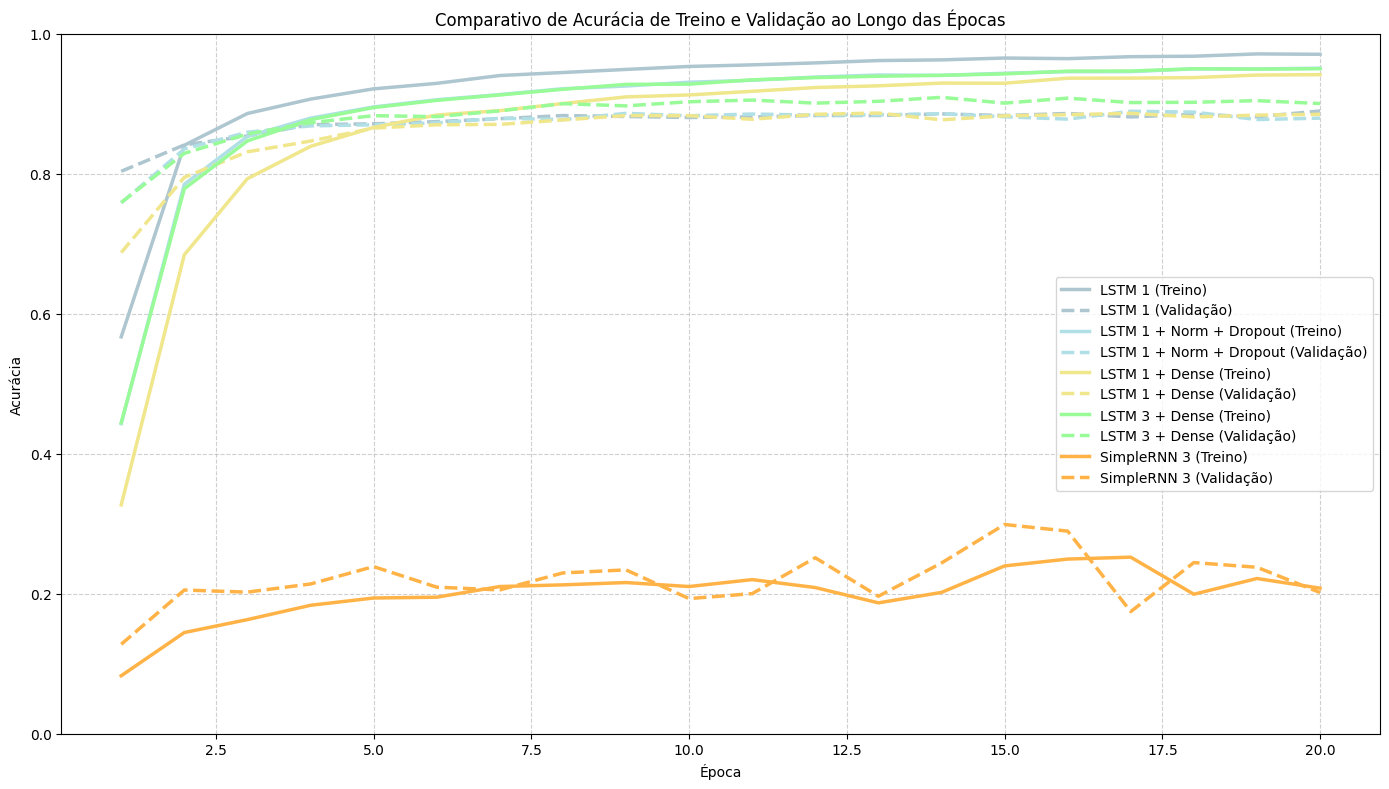

In [11]:
checkpoint_dir = 'checkpoints_models'

history_files = {
    'LSTM 1': 'training_history_lstm_1.json',
    'LSTM 1 + Norm + Dropout': 'training_history_lstm_2.json',
    'LSTM 1 + Dense': 'training_history_lstm_4.json',
    'LSTM 3 + Dense': 'training_history_lstm_5.json',
    'SimpleRNN 3': 'training_history_rnn_1.json'
}

pastel_colors = [
    '#AEC6CF', 
    '#B0E0E6',
    '#F0E68C',
    '#98FB98', 
    '#FFB347', 
    '#E6E6FA', 
    '#FFDAB9', 
]

line_width = 2.5 

loaded_histories = {}

for model_name, filename in history_files.items():
    filepath = os.path.join(checkpoint_dir, filename)
    with open(filepath, 'r') as f:
        history_data = json.load(f)
                
    if 'accuracy' in history_data and 'val_accuracy' in history_data:
        loaded_histories[model_name] = history_data

plt.figure(figsize=(14, 8))

line_styles = {'train': '-', 'val': '--'}

for i, (model_name, history_data) in enumerate(loaded_histories.items()):
    epochs = range(1, len(history_data['accuracy']) + 1)
    color = pastel_colors[i % len(pastel_colors)]

    plt.plot(epochs, history_data['accuracy'],
             label=f'{model_name} (Treino)',
             color=color,
             linestyle=line_styles['train'],
             linewidth=line_width)

    plt.plot(epochs, history_data['val_accuracy'],
             label=f'{model_name} (Validação)',
             color=color,
             linestyle=line_styles['val'],
             linewidth=line_width)

plt.title('Comparativo de Acurácia de Treino e Validação ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim(0, 1) 
plt.grid(True, linestyle='--', alpha=0.6) 
plt.legend(loc='best') 
plt.tight_layout()

plt.show()